In [4]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns
import networkx as nx

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from dkl_explore import get_internals, gauss_DV, power_law ,components

from matplotlib.colors import LogNorm

**Let's select the parameter space**

In [7]:
# Resolution
res = 15

# Pruning parameters
beta = np.linspace(0.001, 5, res)

# Separation parameter
dist = np.linspace(0, 5, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 1000

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

**Print $D_{KL}$ values from saved data and save picture**

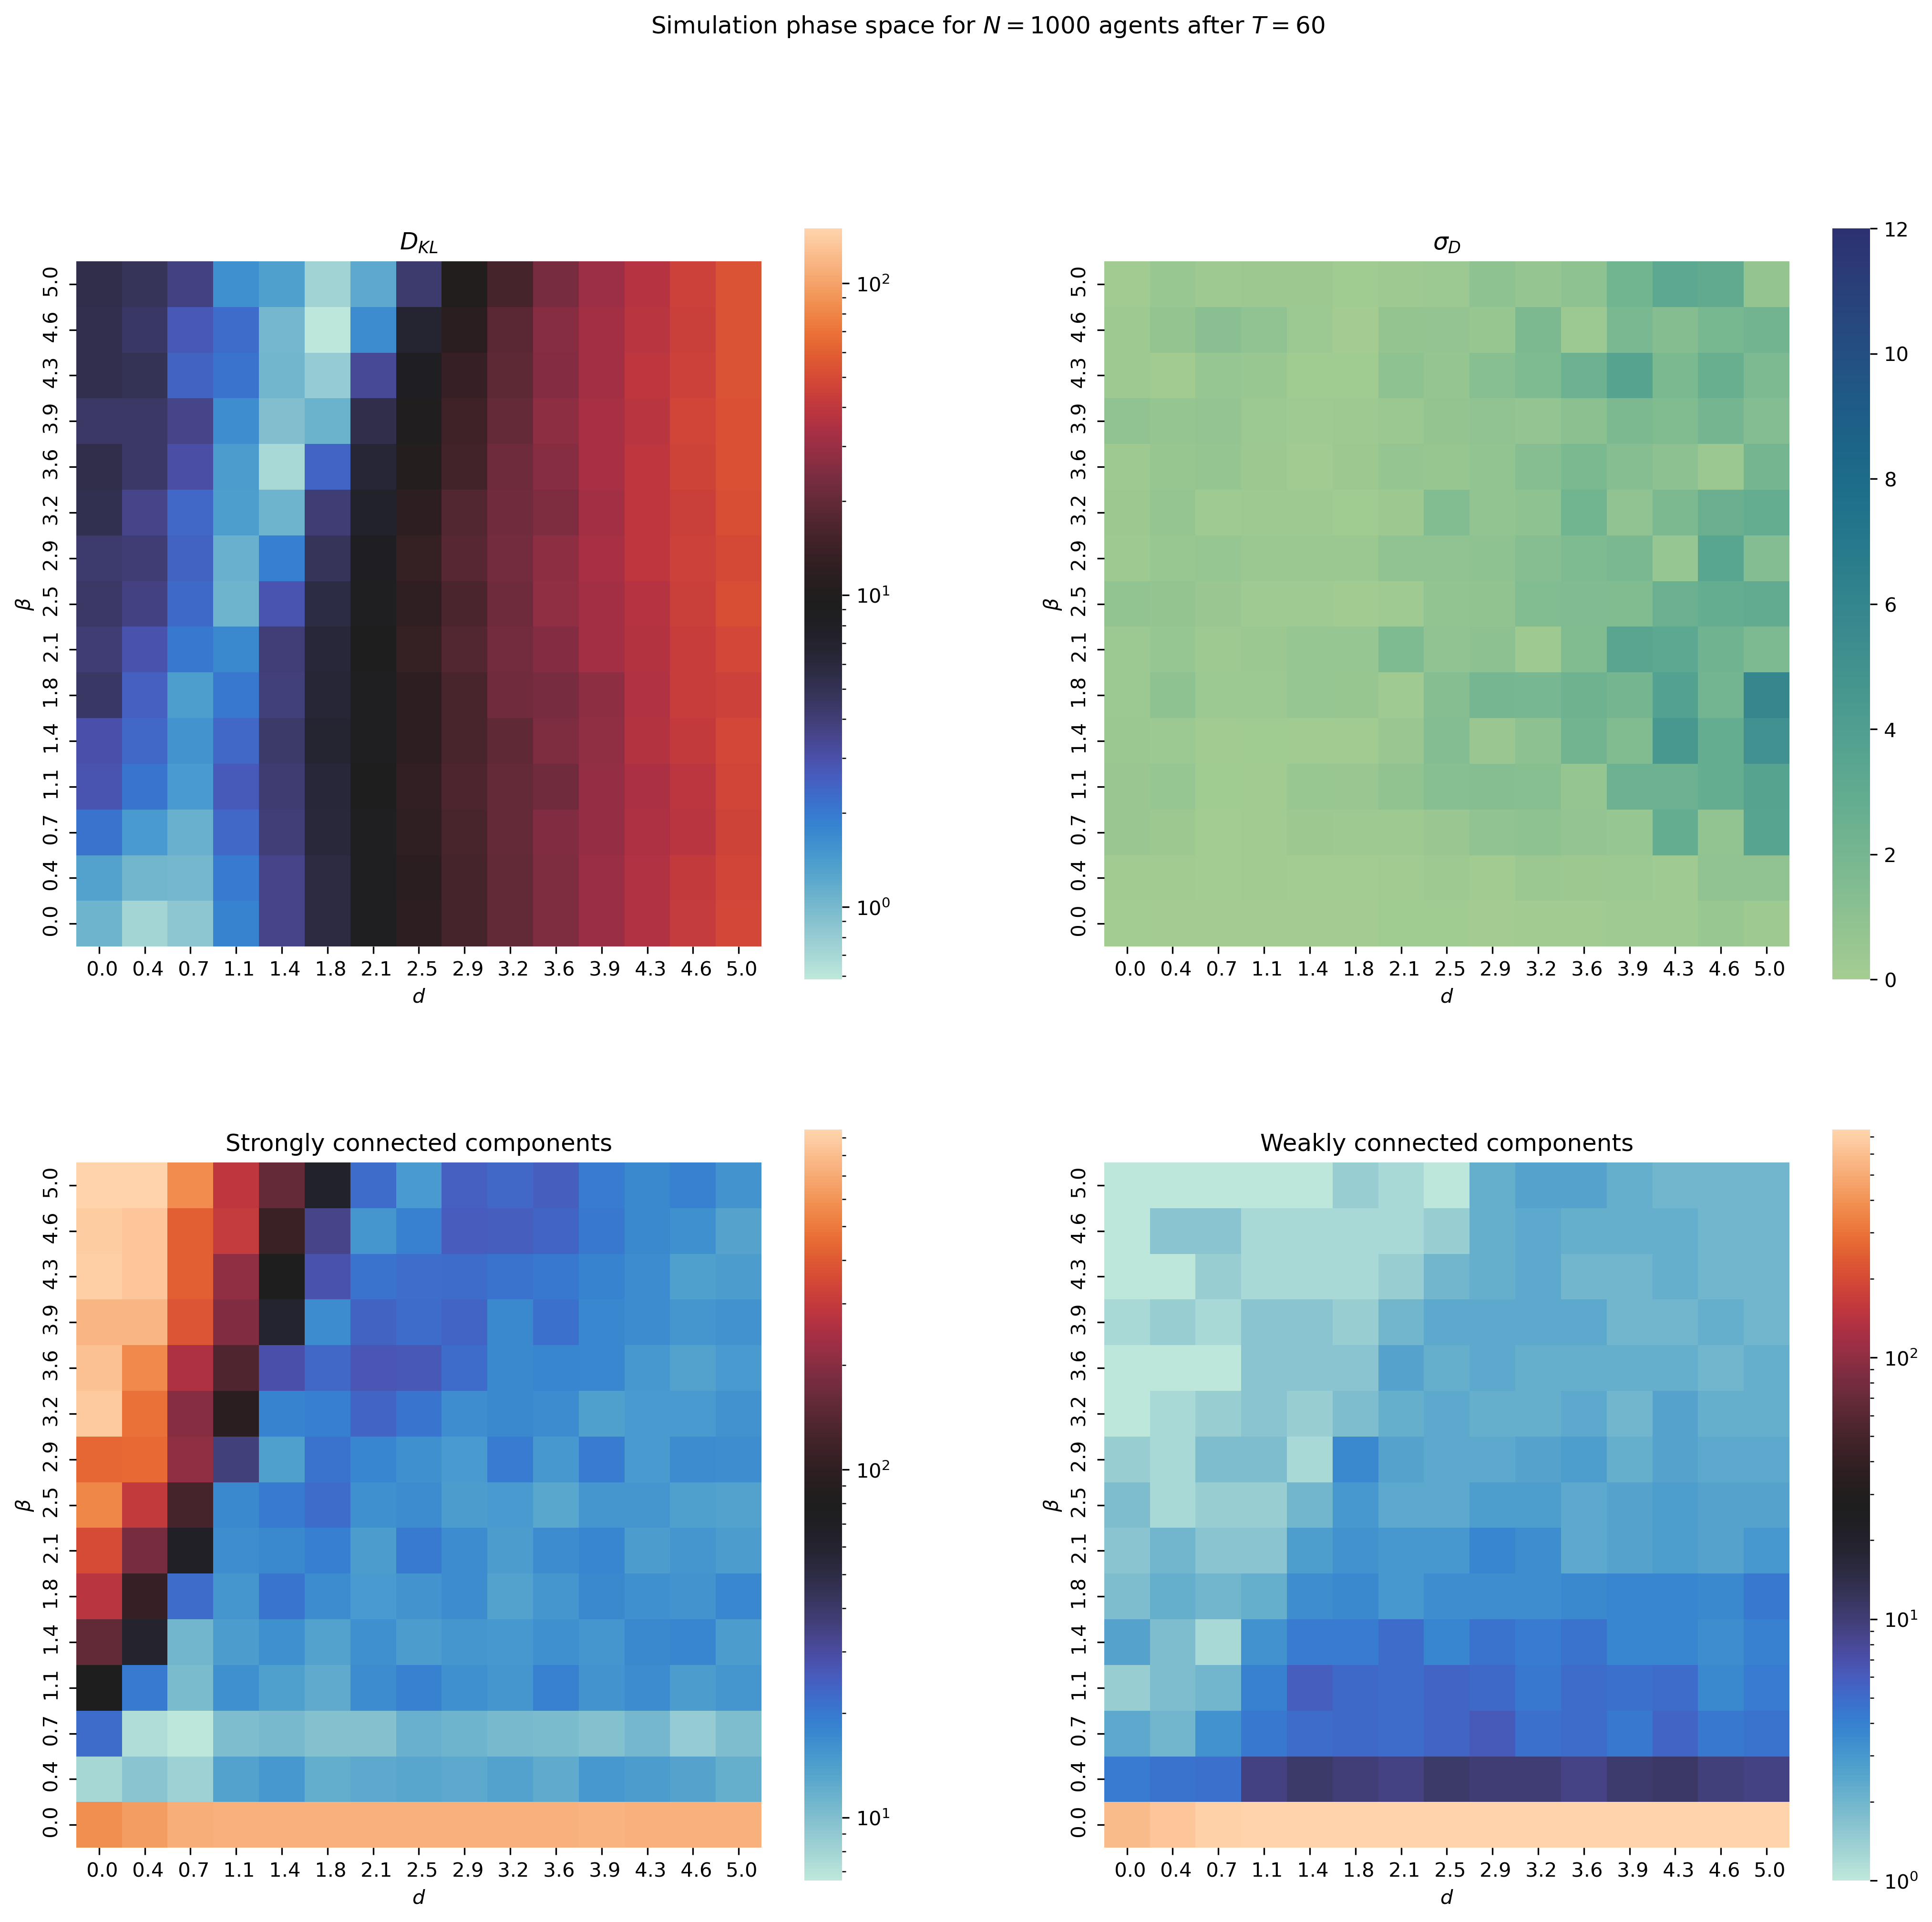

In [8]:
# Load saved arrays


TOT = np.load(sv_pth + str(N) + '_' + str(res) + 'ps.npy').reshape((res,res,6))

DV0 = TOT[:,:,0]
DV0_var = TOT[:,:,1]
DV = TOT[:,:,2]
DV_var = TOT[:,:,3]

SCC = TOT[:,:,4]
WCC = TOT[:,:,5]


# Get labels for graphics
b_st = []
for b in beta:

    b_st.append(f'{b: 0,.1f}')

d_st = []
for dis in dist:

    d_st.append(f'{dis: 0,.1f}')

# Print phase space
fig, ax = plt.subplots(2,2, figsize = (17,15), dpi = 300)

sns.heatmap(DV, norm = LogNorm(vmax = 150), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0][0])
sns.heatmap(np.sqrt(DV_var), vmin = 0, vmax = 12, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[0][1])

sns.heatmap(SCC, norm = LogNorm(), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[1][0])
sns.heatmap(WCC, norm = LogNorm(), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[1][1])

ax[0][0].set_title('$D_{KL}$', )
ax[0][1].set_title('$\\sigma_{D}$')

ax[1][0].set_title('Strongly connected components')
ax[1][1].set_title('Weakly connected components')

for a in ax:
    for b in a:

        b.invert_yaxis()

        b.set_xlabel('$d$')
        b.set_ylabel('$\\beta$')



fig.suptitle('Simulation phase space for $N = 1000$ agents after $T = 60$')

plt.savefig(sv_pth + str(N) + '_' + str(res) + '.png', dpi = 300)
plt.show()

**Simulate single pixels**

In [19]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from dkl_explore import get_internals, gauss_DV, power_law, components

from scipy.stats import norm
from multiprocessing import Pool

from matplotlib.colors import LogNorm

In [20]:
# Select parameters

# Number of agents
Na = 1000
# 
friends = int(np.log(Na) + 0.5)
# Pruning parameter
b = 0.7
# Initial separation of beliefs
d = 2
# Uncertainty on new observation
var_c = 10

# Variance of initial sampling distributions
vartrue = 1

# Duration
t = 60

# Number of simulations
Ns = 5

# Initialize results array
mus = np.empty((0,t+1,Na))
sigmas = mus
nets = []

for i in tqdm(range(0,Ns), desc = 'Running multiple simulations' , leave = True):
    mu, sigma, net = get_internals(N = Na, beta = b,
                    dist = d, var_c = var_c, T = t)
    
    mus = np.concatenate((mus, np.asarray(mu)[np.newaxis,:,:]), axis = 0)
    sigmas = np.concatenate((sigmas, np.asarray(sigma)[np.newaxis,:,:]), axis = 0)

    nets = nets + [net]

print('Done!')

Running multiple simulations: 100%|██████████| 5/5 [01:06<00:00, 13.37s/it]

Done!


**Calculate $D_{KL}$ for the new runs**

In [ ]:
# Compute Divergence time series

# Initialize
DVts = np.empty((0,t+1))

# Set bins for discretization
n_bins = 10

# Compute
for i, mu in enumerate(mus):
    dv = []
    for j, m in enumerate(mu):

        dv.append(gauss_DV(m, power_law(j, d0 = mus[i,0,:].std(), dist = d, friends = friends), nbins = n_bins))
    
    DVts = np.concatenate((DVts, np.asarray(dv)[np.newaxis,:]), axis = 0)

**Calculate strongly and weakly connected components for new runs**

In [22]:
# Initialize result parameters
SCCts = np.empty((0,t+1))
WCCts = np.empty((0,t+1))

ts = [i for i in range(0,t+1)]

# Set multiprocessing parameters
workers = 4
chunksize = 3

# Loop over repeat runs
for i, n in enumerate(nets):

    # Create iterable function
    def it_components(t: int):
        scc, wcc = components(net = n[t], mus = mus[i,t,:], sigmas = sigmas[i,t,:], beta = b)
        return scc, wcc

    # Run multiprocessing over one run
    if __name__ == '__main__':
        with Pool(workers) as p:
            results = list(tqdm(p.imap(it_components, ts, chunksize = chunksize),  
                        
                        desc='Solving simulation ' + str(i+1),               
                        total=len(ts),
                        leave=True)
            )
            
            S = []
            W = []

            for r in results:

                S.append(r[0])
                W.append(r[1])

            S = np.asarray(S)
            W = np.asarray(W)
                
    SCCts = np.concatenate((SCCts, S[np.newaxis,:]), axis = 0)
    WCCts = np.concatenate((WCCts, W[np.newaxis,:]), axis = 0)

print('Done!')

Solving simulation 5: 100%|██████████| 61/61 [00:00<00:00, 83.17it/s]

Done!


**Have a LOOK at it!**

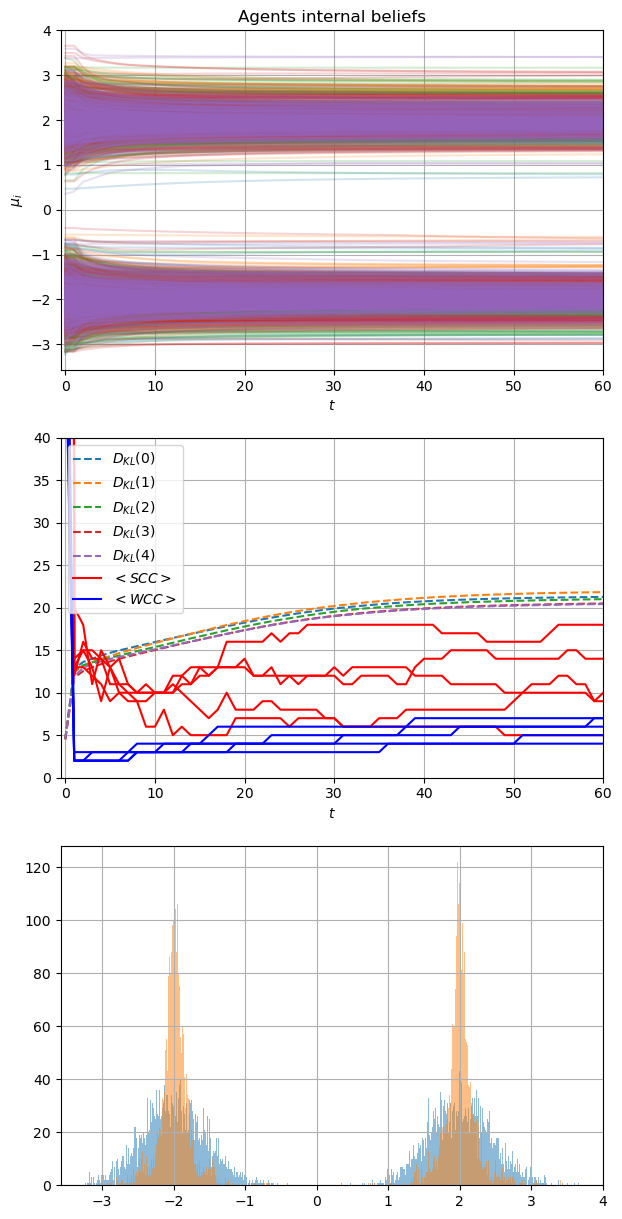

In [24]:
# Show the internal beliefs of agents

fig, axs = plt.subplots(3,1, figsize = (7,15))

for ax in axs:

    ax.grid(True)

    if ax != axs[2]:
        ax.set_xlabel('$t$')
        ax.set_xlim(-0.5,t)

# Plot agent beliefs (Yes, all of them)
for i, mu in enumerate(mus):
    axs[0].plot(mu, 'C' + str(i) + '-', alpha = 0.2)

axs[0].set_ylabel('$\\mu_{i}$')
axs[0].set_title('Agents internal beliefs')

# Compare Divergence values
for i, dv in enumerate(DVts):
    axs[1].plot(dv, '--',  color = 'C' + str(i), label = '$D_{KL}$(' + str(i) + ')')

# Compare strongly connected components
for i, s in enumerate(SCCts):
    if i == 0:
        axs[1].plot(s, '-',  color = 'r', label = '$<SCC>$')
    else:
        axs[1].plot(s, '-',  color = 'r')

# Compare weakly connected components
for i, s in enumerate(WCCts):
    if i == 0:
        axs[1].plot(s, '-',  color = 'b', label = '$<WCC>$')
    else:
        axs[1].plot(s, '-',  color = 'b')


# Compare gaussian variance estimation
#for i, s in enumerate(mus.var(axis = 2)):
#    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

# Compare average agent variances (Kinda useless but it.s here)
#for i, s in enumerate(sigmas.mean(axis = 2)):
#    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

axs[1].set_ylim(0,40)

axs[1].legend()

# Plot histograms for CUMULATIVE initial and final distribution
mu0 = mus[:,0,:].reshape(-1)
mut = mus[:,t,:].reshape(-1)

axs[2].hist(mu0, bins = n_bins*mus.shape[0], alpha = 0.5)
axs[2].hist(mut, bins = n_bins*mus.shape[0], alpha = 0.5)

plt.show()

**See what's happening in each repeat run**

1.0419995126327488
0.5022330097932386


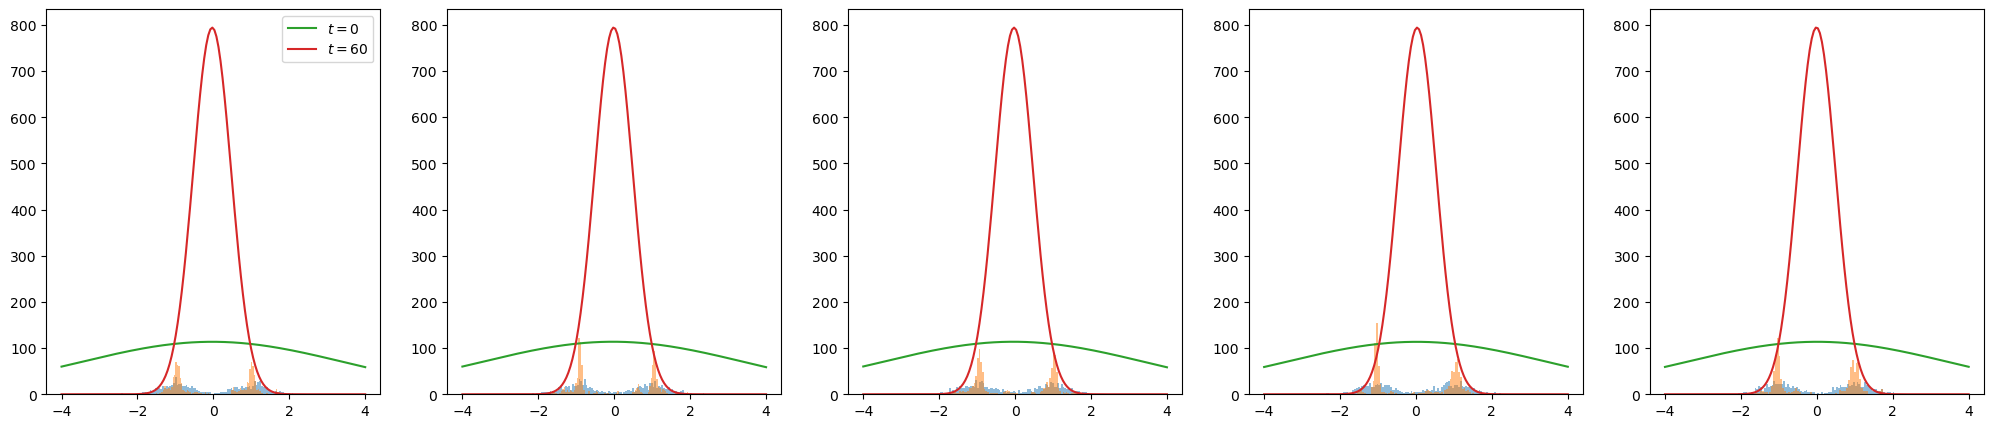

In [ ]:
x = np.linspace(-(d+1)*2,(d+1)*2,150)

fig, ax = plt.subplots(1,Ns, figsize = (Ns*5, 5))

for i, a in enumerate(ax):

    a.hist(mus[i,0,:], bins = n_bins, alpha = 0.5)
    a.hist(mus[i,t,:], bins = n_bins, alpha = 0.5)

    gauss0 = Na*norm.pdf(x, loc = mus[i,0,:].mean(), scale = power_law(0, d0 = mus[i,0,:].std(), dist = d, friends = friends))
    gausst = Na*norm.pdf(x, loc = mus[i,t,:].mean(), scale = power_law(t, d0 = mus[i,0,:].std(), dist = d, friends = friends))

    a.plot(x,gauss0, '-', label = '$t = 0$')
    a.plot(x,gausst, '-', label = '$t = $' + str(t))

ax[0].legend()
print(mus[i,t,:].std())
print(power_law(t, mus[i,0,:].std(), dist = d))
plt.show()

**Check standard deviation prediction**

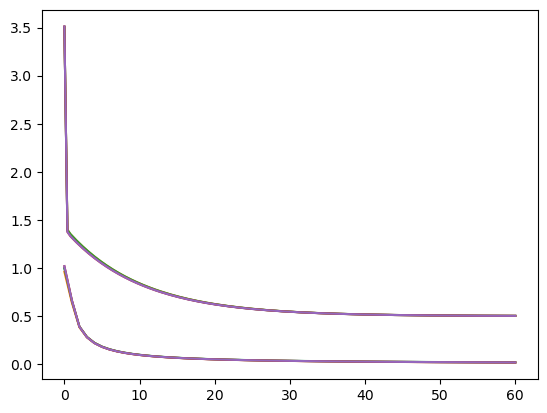

In [86]:
fig, axs = plt.subplots()

x = np.linspace(0,t, 150)

# Compare average agent variances (Kinda useless but it.s here)
for i, s in enumerate(sigmas.mean(axis = 2)):
    axs.plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')
    axs.plot(x, power_law(x, d0 = mus[i,0,:].std(), dist = d), color = 'C' + str(i))